<a href="https://colab.research.google.com/github/harshit-singh-hs/SAR_Despeckling_Using_U-Net/blob/main/SAR_Despeckling_Using_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup & Google Drive Mounting

In [22]:
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Project Configuration
base_dir = '/content/drive/MyDrive/SAR_Project'
data_dir = os.path.join(base_dir, 'dataset')

# Define training paths
noisy_dir = os.path.join(data_dir, 'train', 'noisy')
clean_dir = os.path.join(data_dir, 'train', 'clean')

val_noisy_dir = os.path.join(data_dir, 'val', 'noisy')
val_clean_dir = os.path.join(data_dir, 'val', 'clean')


# Verify dataset availability
if os.path.exists(noisy_dir) and os.path.exists(clean_dir):
    # Count images
    n_noisy = len(os.listdir(val_noisy_dir)) + len(os.listdir(noisy_dir))
    n_clean = len(os.listdir(val_clean_dir)) + len(os.listdir(clean_dir))

    print(f"Dataset Path: {data_dir}")
    print(f"Found {n_noisy} noisy images and {n_clean} clean images.")

    if n_noisy != n_clean:
        print(f"Warning: Data mismatch! ({n_noisy} noisy vs {n_clean} clean)")
else:
    print(f"Error: Dataset directory not found at {data_dir}")
    print("Please check the folder structure in your Google Drive.")

Dataset Path: /content/drive/MyDrive/SAR_Project/dataset
Found 1600 noisy images and 1600 clean images.


### Importing Libraries

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from IPython.display import Image, display
import glob
import rasterio

### Dataset Configuration & Splitting

In [25]:
# Configuration
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 16

In [26]:
X_train = sorted(glob.glob(os.path.join(noisy_dir, '*.tiff')))
y_train = sorted(glob.glob(os.path.join(clean_dir, '*.tiff')))

X_val = sorted(glob.glob(os.path.join(val_noisy_dir, '*.tiff')))
y_val = sorted(glob.glob(os.path.join(val_clean_dir, '*.tiff')))

### Custom Data Generator Pipeline

In [27]:
def load_tiff_image(file_path):
    """Helper function to read .tiff and normalize it to 0-1"""
    with rasterio.open(file_path) as src:
        # Read the first band
        img = src.read(1)
        # Normalize to 0-1 range
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        # Resize to 128x128
        img = tf.image.resize(img[..., np.newaxis], [128, 128]).numpy()
    return img

In [28]:
def data_generator(noisy_list, clean_list, batch_size=16):
    """Generator that yields batches of images """
    while True:
        for i in range(0, len(noisy_list), batch_size):
            batch_noisy_paths = noisy_list[i : i + batch_size]
            batch_clean_paths = clean_list[i : i + batch_size]

            batch_noisy = [load_tiff_image(p) for p in batch_noisy_paths]
            batch_clean = [load_tiff_image(p) for p in batch_clean_paths]

            yield np.array(batch_noisy), np.array(batch_clean)

In [29]:
# Initialize generators
train_gen = data_generator(X_train, y_train, batch_size=16)
val_gen = data_generator(X_val, y_val, batch_size=16)

print(f"Total training pairs: {len(X_train)}")

Total training pairs: 1500


### Visualizing the Raw SAR Data

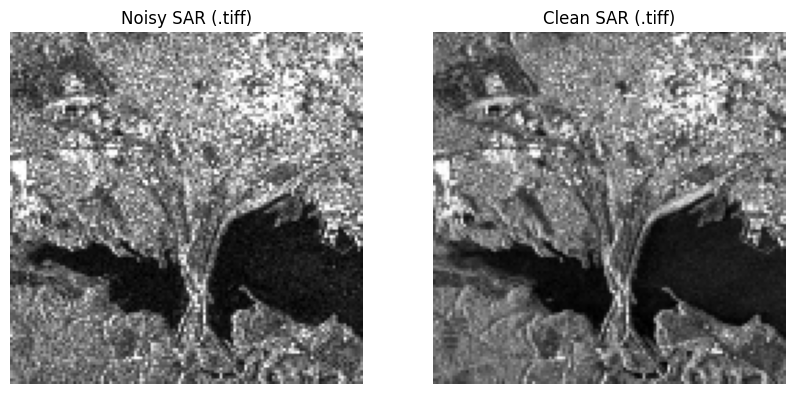

In [30]:
sample_noisy, sample_clean = next(train_gen)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy SAR (.tiff)")
plt.imshow(sample_noisy[0].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Clean SAR (.tiff)")
plt.imshow(sample_clean[0].squeeze(), cmap='gray')
plt.axis('off')

plt.show()

### U-Net Architecture

In [31]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # ENCODER

    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # BOTTLENECK

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # DECODER

    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u3 = layers.concatenate([u3, c3]) # Skip Connection 1
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2]) # Skip Connection 1
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u1 = layers.concatenate([u1, c1]) # Skip Connection 2
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # OUTPUT

    outputs = layers.Conv2D(1, (1, 1), activation='linear')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="SAR_UNet")
    return model


model = build_unet()

model.summary()

Model: "SAR_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_19[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_21[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 32,    │    131,200 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,040 │ concatenate_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │     32,832 │ conv2d_24[0][0] 

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

### Model Visualization

 U-Net Architecture Visualization:


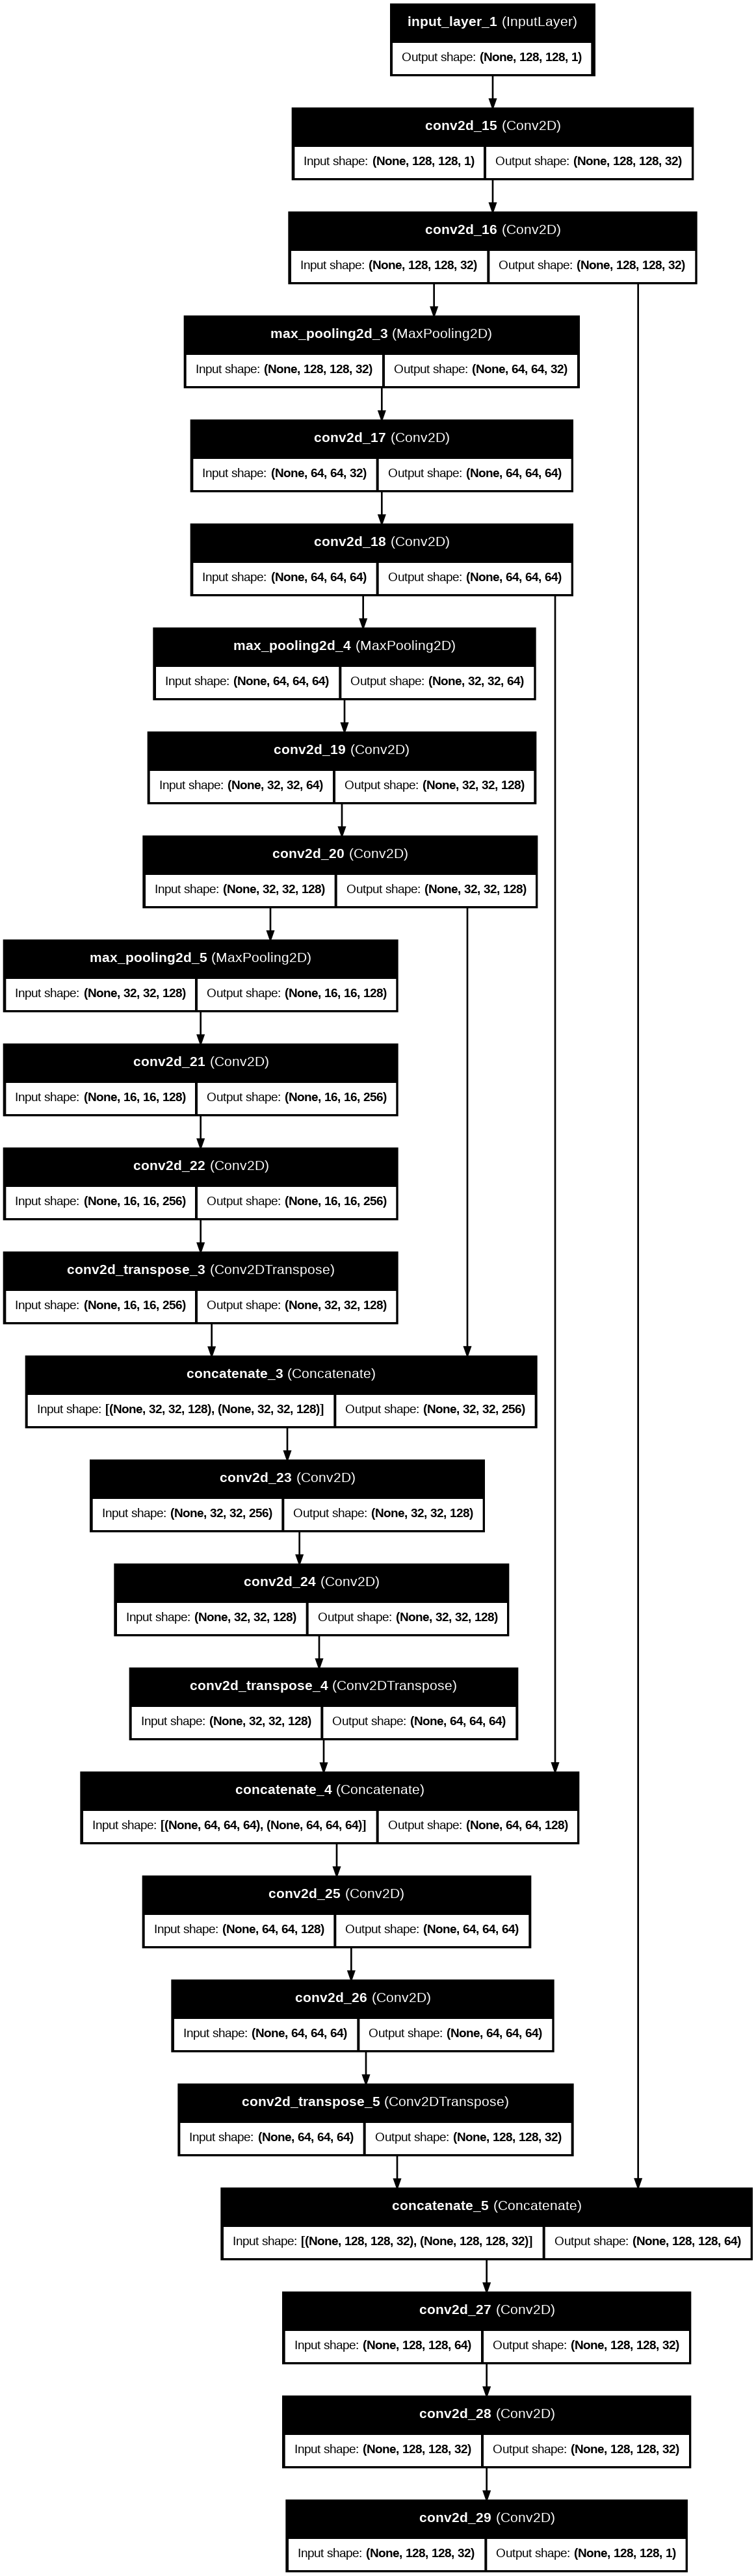

In [32]:
plot_path = 'sar_unet_diagram.png'

plot_model(
    model,
    to_file=plot_path,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

print(" U-Net Architecture Visualization:")
display(Image(plot_path))

### Custom Loss Functions & Metrics

In [33]:
# Custom Loss Function
def ssim_loss(y_true, y_pred):
    """Structural Similarity Loss: 1.0 - SSIM"""
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def hybrid_loss(y_true, y_pred):
    """
    - 80% SSIM (Force it to keep edges sharp)
    - 20% MAE (Just ensure colors/brightness are correct)
    """
    mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)

    return 0.2 * mae + 0.8 * ssim

# Metric: Peak Signal-to-Noise Ratio (PSNR)
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

### Phase 1:Model Compilation & Training

In [12]:
# Compile the Model
model.compile(optimizer='adam', loss=hybrid_loss, metrics=[psnr_metric, 'mae'])

callbacks = [
    ModelCheckpoint('best_sar_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [13]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train) // 16,  # 16 is batch size
    validation_steps=len(X_val) // 16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4238 - mae: 0.1106 - psnr_metric: 19.6060
Epoch 1: val_loss improved from inf to 0.20412, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - loss: 0.4230 - mae: 0.1103 - psnr_metric: 19.6217 - val_loss: 0.2041 - val_mae: 0.0523 - val_psnr_metric: 23.2489 - learning_rate: 0.0010
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3598 - mae: 0.0940 - psnr_metric: 20.5233
Epoch 2: val_loss improved from 0.20412 to 0.20369, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 0.3595 - mae: 0.0938 - psnr_metric: 20.5336 - val_loss: 0.2037 - val_mae: 0.0501 - val_psnr_metric: 23.4427 - learning_rate: 0.0010
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3485 - mae: 0.0881 - psnr_metric: 21.1159
Epoch 3: val_loss improved from 0.20369 to 0.19780, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.3483 - mae: 0.0879 - psnr_metric: 21.1243 - val_loss: 0.1978 - val_mae: 0.0480 - val_psnr_metric: 23.8766 - learning_rate: 0.0010
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3400 - mae: 0.0839 - psnr_metric: 21.5737
Epoch 4: val_loss improved from 0.19780 to 0.19535, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - loss: 0.3398 - mae: 0.0838 - psnr_metric: 21.5784 - val_loss: 0.1953 - val_mae: 0.0472 - val_psnr_metric: 24.0893 - learning_rate: 0.0010
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3323 - mae: 0.0815 - psnr_metric: 21.7574
Epoch 5: val_loss did not improve from 0.19535
93/93 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 0.3322 - mae: 0.0814 - psnr_metric: 21.7612 - val_loss: 0.2006 - val_mae: 0.0478 - val_psnr_metric: 24.2651 - learning_rate: 0.0010
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3276 - mae: 0.0799 - psnr_metric: 22.0061
Epoch 6: val_loss did not improve from 0.19535
93/93 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 0.3276 - mae: 0.0798 - psnr_metric: 22.0081 - val_loss: 0.2007 - val_mae: 0.0516 - val_psnr_metric: 23.7888 - learning_rate: 0.0010
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3227 - mae: 0.0771 - psnr_metric: 22.3629
Epoch 7: val_loss did not improve from 0.19535

Epoch 7: Reduce

### Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


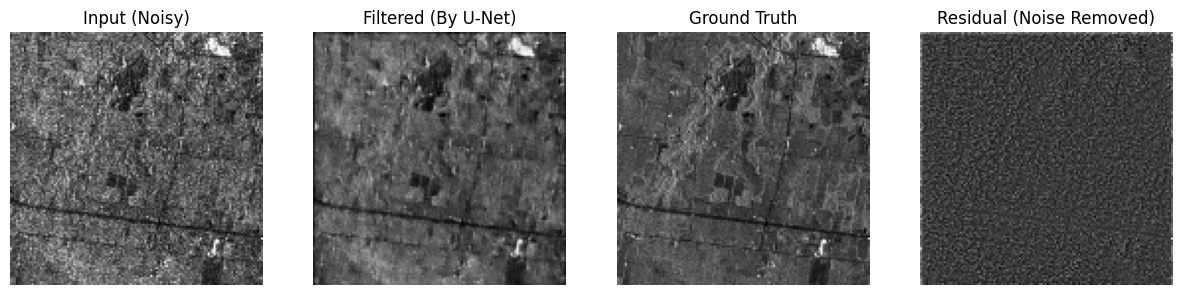

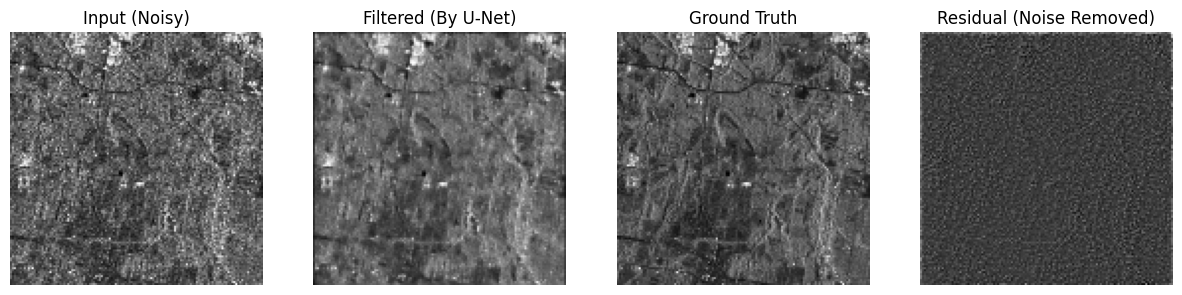

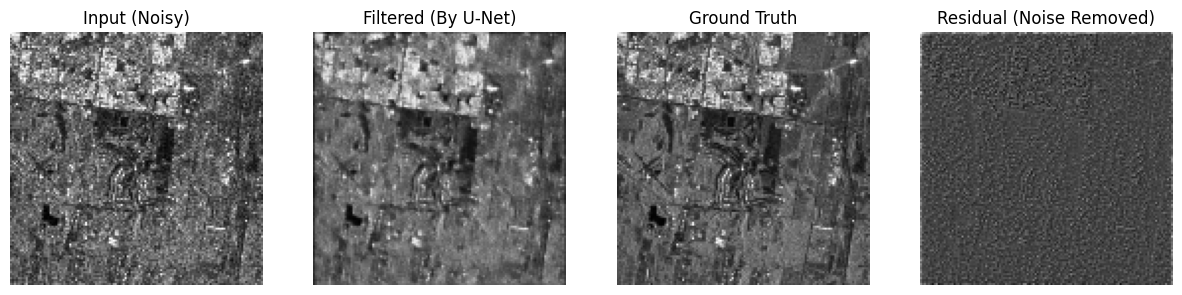

In [14]:
best_model = tf.keras.models.load_model(
    'best_sar_model.h5',
    custom_objects={'hybrid_loss': hybrid_loss, 'psnr_metric': psnr_metric}
)

# Get a single batch of validation images
val_noisy, val_clean = next(val_gen)

# Run Prediction
denoised_images = best_model.predict(val_noisy)

# Plot Results
def plot_results(noisy, clean, denoised, index=0):
    plt.figure(figsize=(15, 5))

    # Noisy Input
    plt.subplot(1, 4, 1)
    plt.title("Input (Noisy)")
    plt.imshow(noisy[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Your Model's Output
    plt.subplot(1, 4, 2)
    plt.title("Filtered (By U-Net)")
    plt.imshow(denoised[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title("Ground Truth")
    plt.imshow(clean[index].squeeze(), cmap='gray')
    plt.axis('off')

    # The Residual
    residual = noisy[index] - denoised[index]
    plt.subplot(1, 4, 4)
    plt.title("Residual (Noise Removed)")
    plt.imshow(residual.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the first 3 images in the batch
for i in range(3):
    plot_results(val_noisy, val_clean, denoised_images, index=i)

### Final Result

In [15]:
avg_psnr = 0
avg_ssim = 0
count = 0

for _ in range(16):
    batch_noisy, batch_clean = next(val_gen)
    batch_pred = best_model.predict(batch_noisy, verbose=0)

    for i in range(len(batch_noisy)):
        # Data must be squeezed and consistent type
        true = batch_clean[i].squeeze()
        pred = batch_pred[i].squeeze()

        avg_psnr += psnr(true, pred, data_range=1.0)
        avg_ssim += ssim(true, pred, data_range=1.0)
        count += 1

print(f"\n FINAL RESULTS:")
print(f"   - Average PSNR: {avg_psnr/count:.2f} dB")
print(f"   - Average SSIM: {avg_ssim/count:.4f} ")


 FINAL RESULTS:
   - Average PSNR: 23.79 dB
   - Average SSIM: 0.7734 


### Phase 2: Fine-Tuning

In [34]:
# Defining Loss Function
def advanced_loss(y_true, y_pred):

    # This combines SSIM, MAE, and Total Variation

    mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    tv = tf.reduce_mean(tf.image.total_variation(y_pred))

    return 1.0 * ssim + 0.5 * mae + 1e-5 * tv

In [35]:
# Loading the previously trained base model

print("Loading the base model...")
finetune_model = tf.keras.models.load_model(
    'best_sar_model.h5',
    custom_objects={'hybrid_loss': hybrid_loss, 'psnr_metric': psnr_metric}
)

Loading the base model...


In [36]:
# Re-compile with a lower learning rate
finetune_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=advanced_loss,
    metrics=[psnr_metric, 'mae']
)

In [37]:
# Setup Callbacks for the fine-tuning phase
callbacks_finetune = [
    ModelCheckpoint('best_sar_model_finetuned.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

In [38]:
history_finetune = finetune_model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train) // 16,
    validation_steps=len(X_val) // 16,
    epochs=30,
    callbacks=callbacks_finetune,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4595 - mae: 0.0785 - psnr_metric: 22.1265
Epoch 1: val_loss improved from inf to 0.28159, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - loss: 0.4592 - mae: 0.0785 - psnr_metric: 22.1313 - val_loss: 0.2816 - val_mae: 0.0495 - val_psnr_metric: 23.9921 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4723 - mae: 0.0827 - psnr_metric: 22.0139
Epoch 2: val_loss improved from 0.28159 to 0.28019, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - loss: 0.4719 - mae: 0.0826 - psnr_metric: 22.0206 - val_loss: 0.2802 - val_mae: 0.0456 - val_psnr_metric: 24.6598 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4620 - mae: 0.0798 - psnr_metric: 22.2307
Epoch 3: val_loss improved from 0.28019 to 0.27590, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - loss: 0.4617 - mae: 0.0797 - psnr_metric: 22.2359 - val_loss: 0.2759 - val_mae: 0.0459 - val_psnr_metric: 24.5984 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4528 - mae: 0.0775 - psnr_metric: 22.4095
Epoch 4: val_loss improved from 0.27590 to 0.27580, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - loss: 0.4526 - mae: 0.0774 - psnr_metric: 22.4130 - val_loss: 0.2758 - val_mae: 0.0461 - val_psnr_metric: 24.6270 - learning_rate: 1.0000e-04
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4430 - mae: 0.0752 - psnr_metric: 22.6186
Epoch 5: val_loss did not improve from 0.27580
93/93 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 0.4429 - mae: 0.0751 - psnr_metric: 22.6201 - val_loss: 0.2799 - val_mae: 0.0460 - val_psnr_metric: 24.7192 - learning_rate: 1.0000e-04
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4369 - mae: 0.0738 - psnr_metric: 22.8321
Epoch 6: val_loss did not improve from 0.27580

Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
93/93 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - loss: 0.4368 - mae: 0.0737 - psnr_metric: 22.8320 - val_loss: 0.2791 - val_mae: 0.0461 - val_psnr_metric: 24.6996 - learning_rate: 1.0000e-04
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4316 - mae: 0.07

93/93 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - loss: 0.4160 - mae: 0.0682 - psnr_metric: 23.2816 - val_loss: 0.2755 - val_mae: 0.0470 - val_psnr_metric: 24.5315 - learning_rate: 2.5000e-05
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4099 - mae: 0.0674 - psnr_metric: 23.3355
Epoch 11: val_loss improved from 0.27549 to 0.27298, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - loss: 0.4101 - mae: 0.0674 - psnr_metric: 23.3309 - val_loss: 0.2730 - val_mae: 0.0465 - val_psnr_metric: 24.5950 - learning_rate: 2.5000e-05
Epoch 12/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4037 - mae: 0.0659 - psnr_metric: 23.4784
Epoch 12: val_loss did not improve from 0.27298
93/93 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - loss: 0.4039 - mae: 0.0660 - psnr_metric: 23.4730 - val_loss: 0.2773 - val_mae: 0.0460 - val_psnr_metric: 24.6888 - learning_rate: 2.5000e-05
Epoch 13/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4018 - mae: 0.0656 - psnr_metric: 23.4240
Epoch 13: val_loss did not improve from 0.27298
93/93 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 0.4021 - mae: 0.0657 - psnr_metric: 23.4190 - val_loss: 0.2767 - val_mae: 0.0463 - val_psnr_metric: 24.6376 - learning_rate: 2.5000e-05
Epoch 14/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3959 - mae: 0.0644 - psnr_metric: 23.5544
Epoch 14: val_loss did not improve from 0.2729

### Visualization

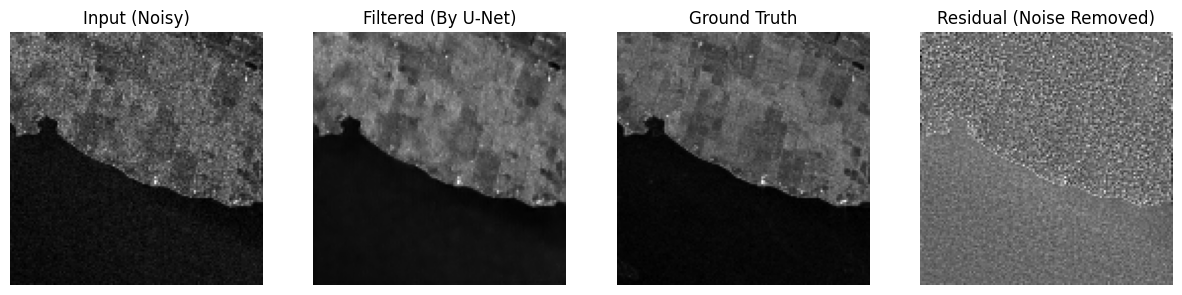

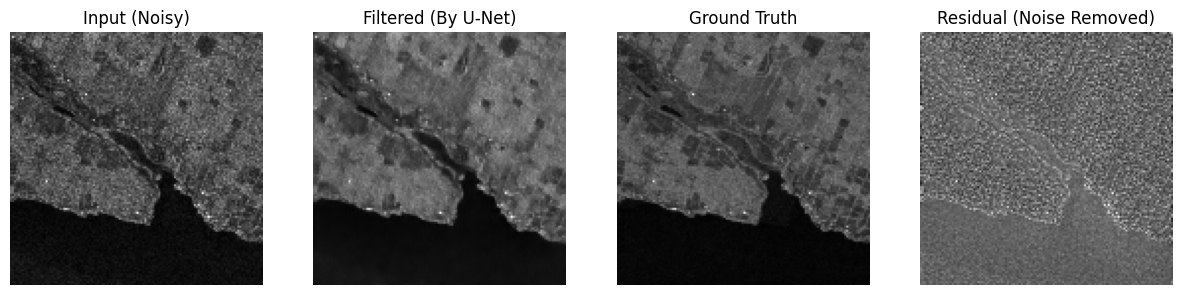

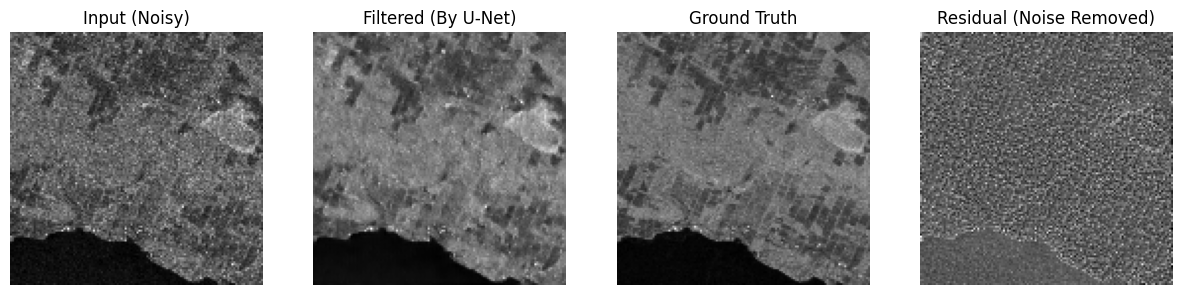

In [39]:
best_finetuned = tf.keras.models.load_model(
    'best_sar_model_finetuned.h5',
    custom_objects={'advanced_loss': advanced_loss, 'psnr_metric': psnr_metric}
)
val_noisy_ft, val_clean_ft = next(val_gen)
denoised_ft = best_finetuned.predict(val_noisy_ft, verbose=0)
for i in range(3):
    plot_results(val_noisy_ft, val_clean_ft, denoised_ft, index=i)

### Final Result

In [40]:
# Final Evaluation
avg_psnr_ft = 0
avg_ssim_ft = 0
count_ft = 0

for _ in range(16):
    batch_noisy, batch_clean = next(val_gen)
    batch_pred = best_finetuned.predict(batch_noisy, verbose=0)

    for i in range(len(batch_noisy)):
        true = batch_clean[i].squeeze()
        pred = batch_pred[i].squeeze()

        avg_psnr_ft += psnr(true, pred, data_range=1.0)
        avg_ssim_ft += ssim(true, pred, data_range=1.0)
        count_ft += 1

print("\nFinal Fine-Tuned Scores:")
print(f"   - Average PSNR: {avg_psnr_ft/count_ft:.2f} dB")
print(f"   - Average SSIM: {avg_ssim_ft/count_ft:.4f} ")


Final Fine-Tuned Scores:
   - Average PSNR: 24.16 dB
   - Average SSIM: 0.7779 
